## Code to Chapter 10 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1z12zX5fUzwes3oC0izbisf9nAoB6Hpi7?usp=sharing)

## LangSmith Tutorial - Building a RAG System with Tracing

This tutorial demonstrates how to build a Retrieval-Augmented Generation (RAG) system using LangChain and LangGraph, with comprehensive tracing capabilities provided by LangSmith. We'll create a system that can answer questions about a scientific paper on protein generative models.

## Overview

In this tutorial, we will:
1. Set up LangSmith for tracing and monitoring
2. Download and process a PDF research paper
3. Build a vector store for document retrieval
4. Create a RAG pipeline using LangGraph
5. Test the system with scientific questions


## 1. Environment Setup and Package Installation

**What these packages do:**
- `langchain`: Core framework for building LLM applications
- `langgraph`: Graph-based workflow orchestration for complex AI applications
- `langchain_community`: Community-contributed integrations and tools
- `langchain_openai`: OpenAI-specific integrations
- `openai`: Official OpenAI Python client
- `pypdf`: PDF processing library for document loading

In [1]:
!pip install -q langchain langgraph langchain_community langchain_openai openai pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.7/309.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.7 MB/s eta 0:00:00


In [2]:
!pip freeze | grep "lang\|openai"

google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.2
langchain==0.3.26
langchain-community==0.3.27
langchain-core==0.3.70
langchain-openai==0.3.28
langchain-text-splitters==0.3.8
langcodes==3.5.0
langgraph==0.5.4
langgraph-checkpoint==2.1.1
langgraph-prebuilt==0.5.2
langgraph-sdk==0.1.74
langsmith==0.4.8
language_data==1.3.0
libclang==18.1.1
openai==1.97.0


## 2. LangSmith Configuration for Tracing

LangSmith provides powerful observability features for LangChain applications, allowing us to trace, monitor, and debug our RAG system.

**Key Configuration Points:**
- **LANGSMITH_TRACING**: Enables automatic tracing of all LangChain operations
- **LANGSMITH_PROJECT**: Groups related traces together for better organization
- **LANGSMITH_ENDPOINT**: Points to the LangSmith API service

**What you'll see in LangSmith:**
- Token usage and costs
- Latency measurements
- Input/output for each component
- Error tracking and debugging information

In [3]:
import os
import openai
from google.colab import userdata


os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "lc4ls_ch10"

os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")

In [4]:
os.makedirs("./data", exist_ok=True)

## 3. Document Acquisition and Storage

We'll download a research paper about protein generative models to use as our knowledge base.

**Our RAG approach:**
- **Headers**: Mimic a real browser to avoid being blocked by servers
- **Local storage**: Ensures consistent access to the document during development
- **Error handling**: In production, you'd want to add try-catch blocks here

In [5]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36",
    "Referer": "https://github.com/IvanReznikov/LangChain4LifeScience/blob/main/data/articles/2410.20354v4.pdf",
}

response = requests.get(
    "https://raw.githubusercontent.com/IvanReznikov/LangChain4LifeScience/refs/heads/main/data/articles/2410.20354v4.pdf",
    headers=headers,
)

pdf_path = "./data/article.pdf"
with open(pdf_path, "wb") as f:
    f.write(response.content)

## 4. Core Imports and Dependencies

Import all necessary components for building our RAG system.

**Key Components:**
- **Document Loaders**: Extract text from various sources (PDF, web, etc.)
- **Text Splitters**: Break documents into manageable chunks
- **Vector Stores**: Store and search document embeddings
- **LangGraph**: Create structured workflows with state management


In [6]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini")

## 5. State Management with LangGraph

**State Management Benefits:**
- **Type Safety**: Ensures data consistency across pipeline steps
- **Traceability**: LangSmith can track how state changes at each step
- **Debugging**: Clear visibility into intermediate results
- **Modularity**: Each step has well-defined inputs and outputs

In [8]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## 6. Pipeline Functions

### Document Retrieval and Answer Generation Functions

**Function Design Principles:**
- **Single Responsibility**: Each function has one clear purpose
- **State Immutability**: Functions return updates rather than modifying state directly
- **Error Resilience**: In production, add error handling for API failures

In [9]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## 7. Document Processing Pipeline

Load and process the PDF document for retrieval.

**Text Splitting Strategy:**
- **Chunk Size (1000)**: Balances context richness with processing efficiency
- **Overlap (100)**: Prevents information loss at chunk boundaries
- **Recursive Splitting**: Splits on natural boundaries (paragraphs, sentences, words)


In [10]:
loader = PyPDFLoader("./data/article.pdf")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs = text_splitter.split_documents(documents)
vector_store = InMemoryVectorStore(OpenAIEmbeddings(model="text-embedding-3-large"))

### Vector Store Creation

**Embedding Model Choice:**
- **text-embedding-3-large**: OpenAI's most capable embedding model
- **High Dimensionality**: Better semantic understanding
- **Trade-off**: Higher accuracy vs. increased computational cost

In [11]:
vector_store.add_documents(documents=docs)

['89beb7f7-709b-429f-8e52-3fe7ce0e3ac7',
 'b38aaf12-d30e-4beb-91c3-26fd917c5935',
 'e8b42a86-6bfe-49bc-ab55-8810399b2f3c',
 '677fe1fd-b274-45b9-a8f1-567406610fa3',
 'f966beb3-c9ea-4079-98a3-68e85e9170c1',
 '0b941487-978a-4f4d-acea-5dcfbddea0bd',
 '8576b455-0e13-4c56-986e-121cef4c6364',
 'b432fc32-471f-4d3e-8725-7b7e7d9fd67c',
 'a3bcbf2c-4ebe-4660-a7f8-374858a8d3f4',
 'd12c85fa-8c1c-4006-8e62-9a67bd9b67d5',
 'ffec4ff9-6997-4621-81bc-e58de56b2a9f',
 '17344b3e-3b18-4f7f-a69b-4ef29af70603',
 '82806db8-828b-41ab-ab5f-8be0753a144f',
 '6bd26025-df3d-4192-8617-999fb36b08c4',
 'cc91f3c6-4552-46bf-9195-99447a494ade',
 'cab38069-ea47-4695-9f49-c8a5ccd773a3',
 '7144ac31-ae68-4459-af50-d87225a87d30',
 'c5f825d6-e3c0-4267-8c30-414f71f286b1',
 '376d7754-5bda-43e9-9d8d-6f6bbaa1482b',
 '9939d7ee-289b-498d-8fc9-bbf0b68cab4e',
 '97479367-5ba2-419a-b761-8ddd43e4f63e',
 'dfd406d5-9c66-46fb-bb3d-81cf07ad9020',
 '7edd1a75-209a-40a9-a4fb-b8a09fd9fb95',
 'a05c06bc-8f95-4bc0-a608-51552a2574a0',
 '5fffa7a1-4b53-

### Prompt Template

**LangChain Hub Benefits:**
- **Community Tested**: Proven prompt templates
- **Optimized**: Designed for specific use cases like RAG
- **Consistent**: Standardized format for question-context-answer structure

In [12]:
prompt = hub.pull("rlm/rag-prompt")

## 8. Graph Construction and Compilation

Build the complete RAG pipeline using LangGraph

**Graph Architecture:**
```
START → retrieve → generate → END
```

**Execution Flow:**
1. **START**: Initialize with user question
2. **retrieve**: Find relevant documents using vector similarity
3. **generate**: Create answer using retrieved context
4. **END**: Return final answer

In [13]:
# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

## 9. Testing the RAG System

Test our system with a domain-specific question:

In [14]:
query = "What are the benefits of watermarking protein generative models?"

response = graph.invoke({"question": query})
print(response["answer"])

The benefits of watermarking protein generative models include copyright authentication and tracking of generated structures, which help address ethical concerns such as protection of intellectual property. The proposed method, FoldMark, allows for the embedding of user-specific information in protein structures while maintaining their quality and biological functionality. It is robust against post-processing and adaptive attacks, ensuring effective protection of AI-generated content.


## 10. LangSmith Tracing Results

After running the query, check your LangSmith dashboard to see:

### Trace Information:
- **Total Execution Time**: End-to-end latency
- **Token Usage**: Input and output tokens for cost tracking
- **Step-by-Step Breakdown**: Detailed view of retrieve and generate functions

### Performance Metrics:
- **Retrieval Quality**: Which documents were selected and why
- **Generation Efficiency**: LLM response time and token consumption
- **Error Tracking**: Any failures or warnings in the pipeline

### Debugging Capabilities:
- **Input/Output Inspection**: View exact data at each step
- **Performance Bottlenecks**: Identify slow components
- **Cost Analysis**: Track API usage and expenses

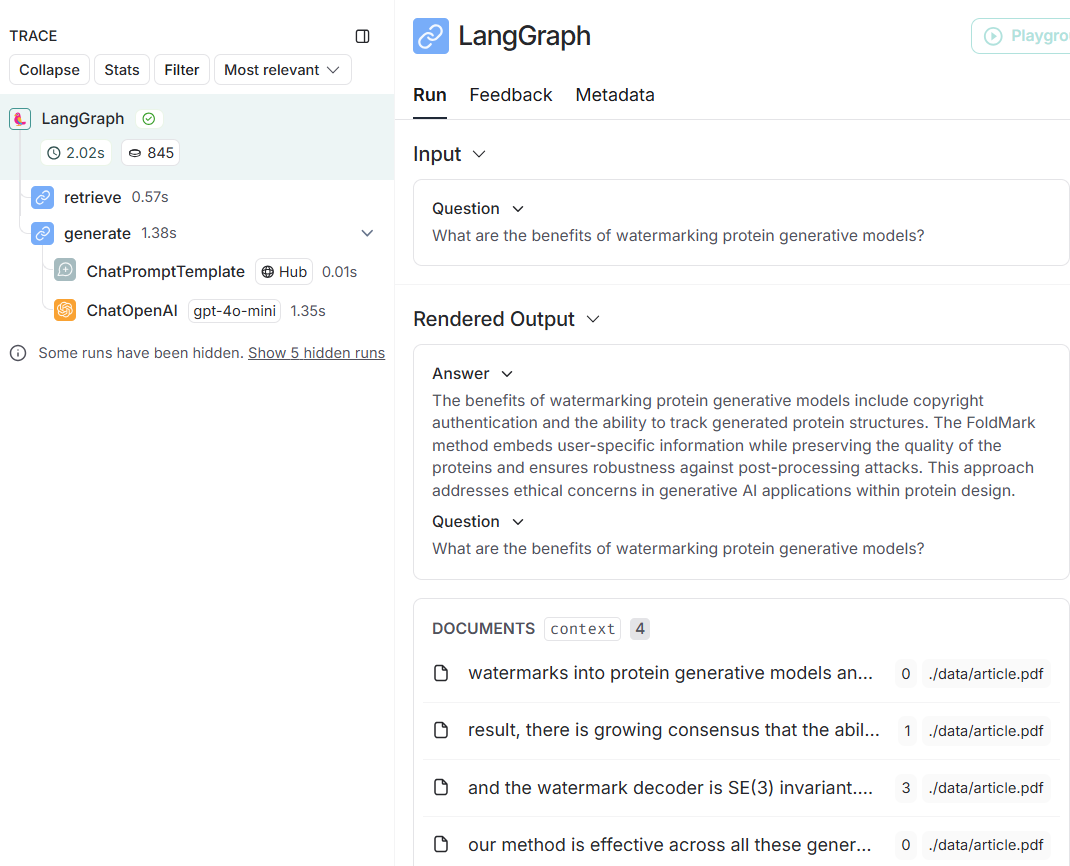